In [22]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

from dynchro.tl import dtw, traceback, warp_pseudotime, dynchronize, get_kde_eval, get_wasserstein_distance, get_cutoff_kde
from dynchro.pl import plot_distance_matrix, plot_cost_matrix, plot_dtw_matrices, plot_kde_comparison

from utils import plot_iroot, comp_kde, kdeplot, kdeplot2, compare, norm

random.seed(34)
np.random.seed(34)

In [2]:
%load_ext autoreload
%autoreload 2

# 1. Read in data

In [3]:
d1 = ad.read_h5ad("data/dynchro1_slingshot_processed.h5ad")
d2 = ad.read_h5ad("data/dynchro2_slingshot_processed.h5ad")
d2.obs["milestones"] = d2.obs.milestones.cat.rename_categories({'sC': 'sC_batch'})

In [4]:
d1.X = d1.layers["X"]
d2.X = d2.layers["X"]

# 2. Sort lineages

In [5]:
def get_sorted_lineage(d, pseudotime_col, lineage_col):
    lineage = d[d.obs[lineage_col] == "TRUE"]
    sorting = np.argsort(lineage.obs[pseudotime_col])
    sorted_lin = lineage[sorting, :]
    return sorted_lin

In [6]:
d1_linC = get_sorted_lineage(d1, "orig_linC_pseudotime", "linC")
d1_linD = get_sorted_lineage(d1, "orig_linD_pseudotime", "linD")
d2_linC = get_sorted_lineage(d2, "orig_linC_pseudotime", "linC")
d2_linD = get_sorted_lineage(d2, "orig_linD_pseudotime", "linD")

In [7]:
d1_linC.obs["orig_pseudotime"] = d1_linC.obs["orig_linC_pseudotime"]
d2_linC.obs["orig_pseudotime"] = d2_linC.obs["orig_linC_pseudotime"]
d1_linD.obs["orig_pseudotime"] = d1_linD.obs["orig_linD_pseudotime"]
d2_linD.obs["orig_pseudotime"] = d2_linD.obs["orig_linD_pseudotime"]

/tmp/ipykernel_125180/3163897231.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d1_linC.obs["orig_pseudotime"] = d1_linC.obs["orig_linC_pseudotime"]
/tmp/ipykernel_125180/3163897231.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d2_linC.obs["orig_pseudotime"] = d2_linC.obs["orig_linC_pseudotime"]
/tmp/ipykernel_125180/3163897231.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d1_linD.obs["orig_pseudotime"] = d1_linD.obs["orig_linD_pseudotime"]
/tmp/ipykernel_125180/3163897231.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d2_linD.obs["orig_pseudotime"] = d2_linD.obs["orig_linD_pseudotime"]


# 3. Dynchronize

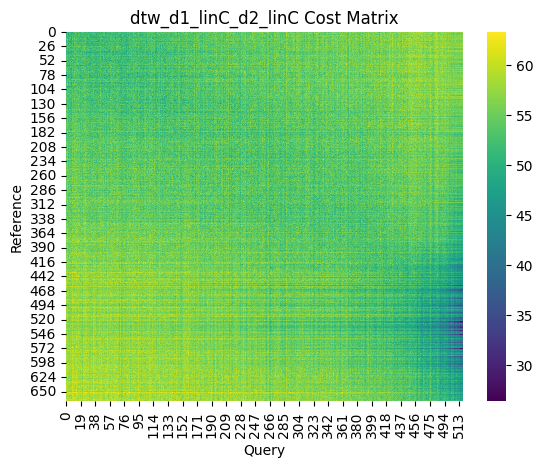

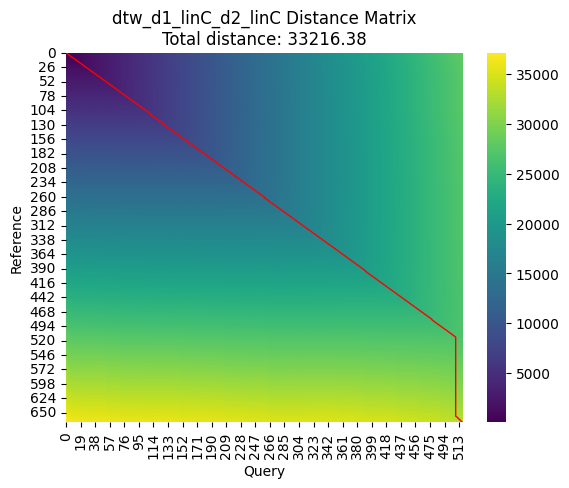

In [8]:
dynchronize(d1_linC, d2_linC, dtw_key="dtw_d1_linC_d2_linC", pseudotime_key="orig_pseudotime")

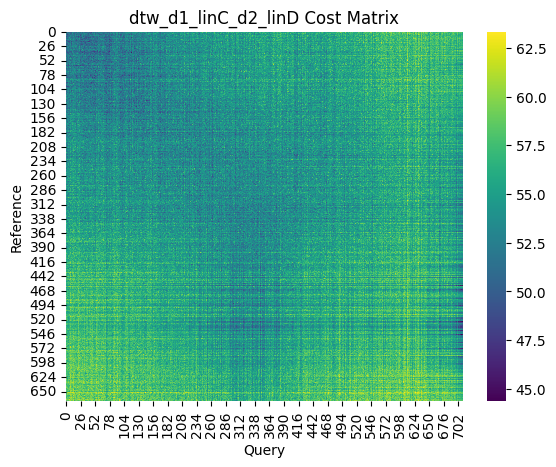

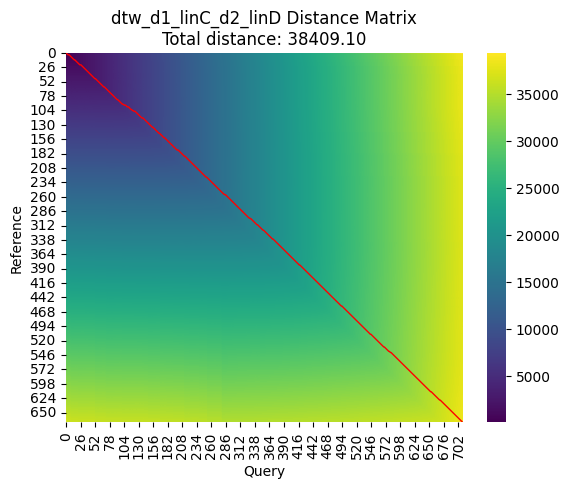

In [9]:
dynchronize(d1_linC, d2_linD, dtw_key="dtw_d1_linC_d2_linD", pseudotime_key="orig_pseudotime")

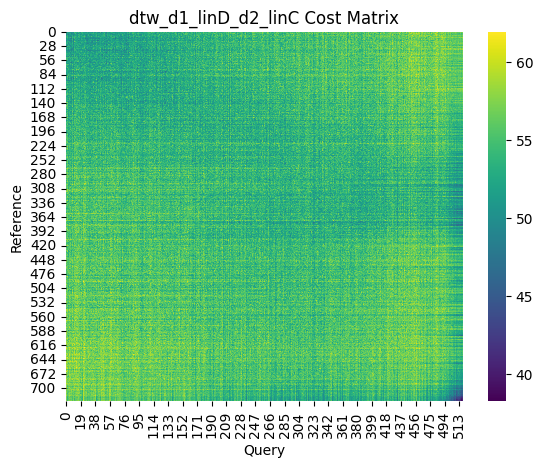

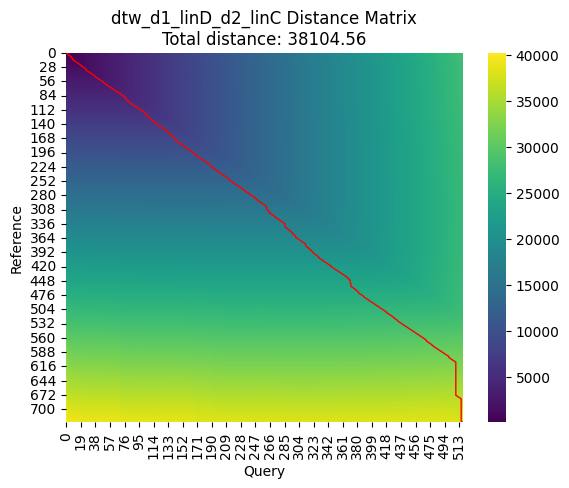

In [10]:
dynchronize(d1_linD, d2_linC, dtw_key="dtw_d1_linD_d2_linC", pseudotime_key="orig_pseudotime")

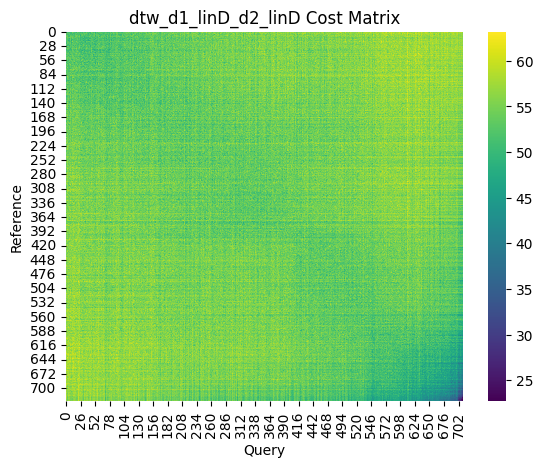

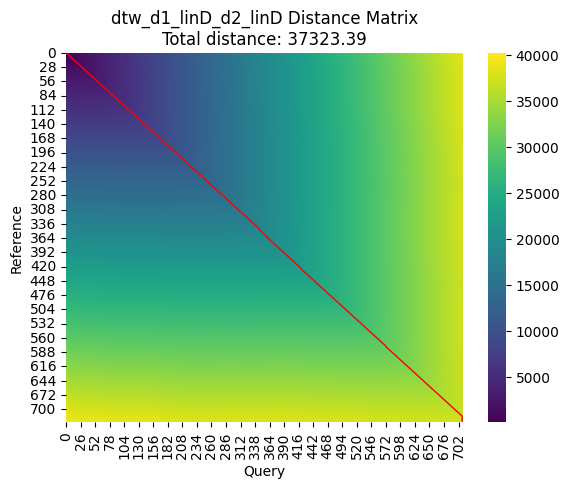

In [11]:
dynchronize(d1_linD, d2_linD, dtw_key="dtw_d1_linD_d2_linD", pseudotime_key="orig_pseudotime")

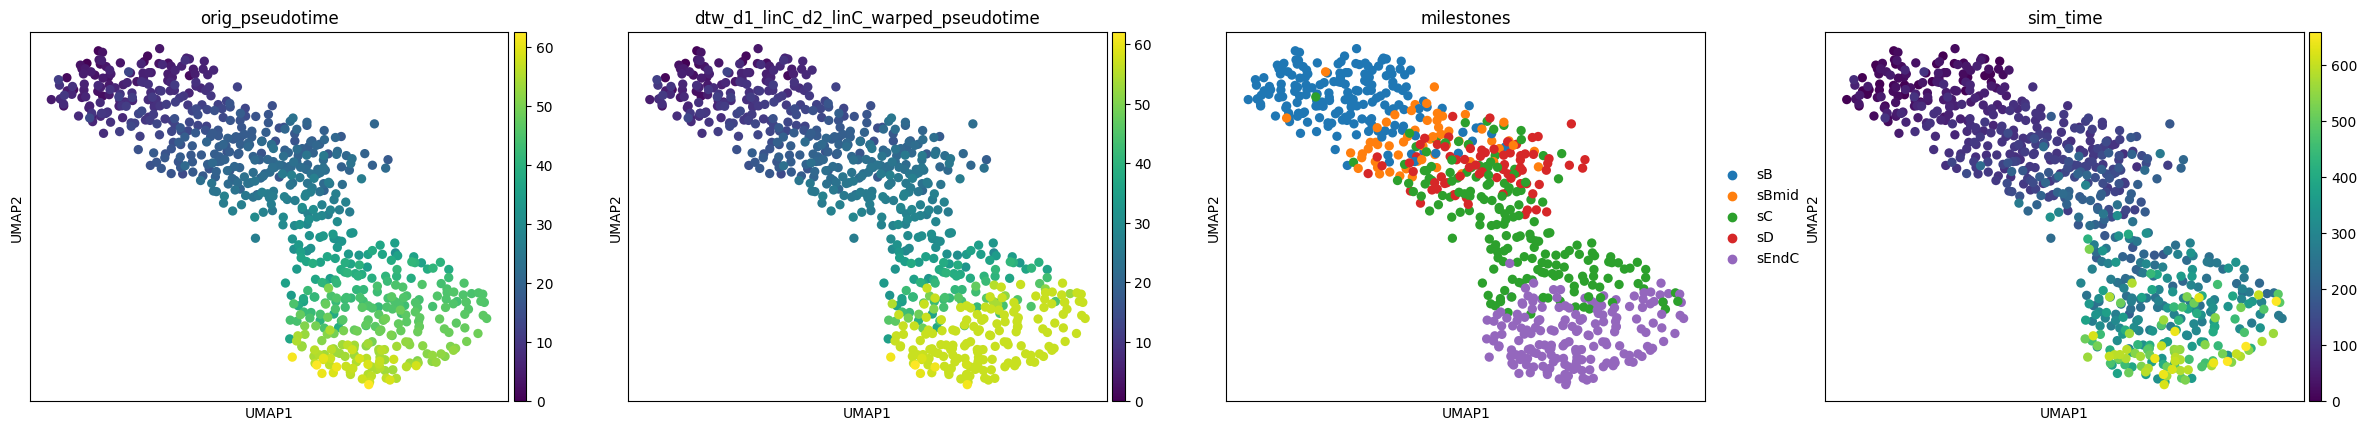

In [12]:
sc.pl.umap(d1_linC, color=["orig_pseudotime", "dtw_d1_linC_d2_linC_warped_pseudotime", "milestones", "sim_time"])

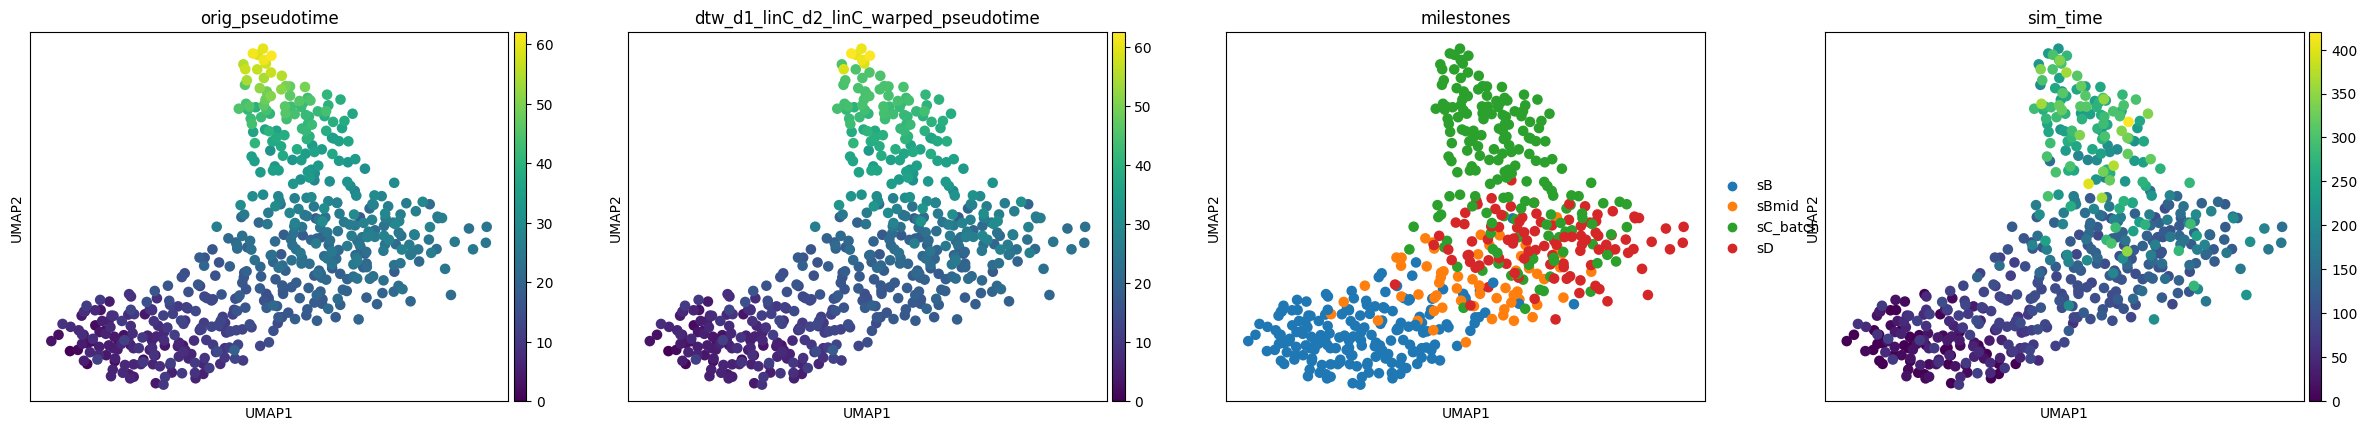

In [13]:
sc.pl.umap(d2_linC, color=["orig_pseudotime", "dtw_d1_linC_d2_linC_warped_pseudotime", "milestones", "sim_time"])

# 4. Compute metrics

In [14]:
linC = ad.concat([d1_linC, d2_linC], axis=0)
linD = ad.concat([d1_linD, d2_linD], axis=0)

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [15]:
# this should be stored in the object too, under uns[dtw_key_kde_x] and uns[dtw_key_kde_y]?
get_kde_eval(linC, "dtw_d1_linC_d2_linC_warped_pseudotime")
get_kde_eval(linC, "orig_pseudotime")

/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:18: UserWarning: Vector dtw_d1_linC_d2_linC_warped_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_dtw_d1_linC_d2_linC_warped_pseudotime'.
  warn(f"Vector {pseudotime_key} is not normalized between 0 and 1. Normalizing it now and storing as 'norm_{pseudotime_key}'.")
/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:18: UserWarning: Vector orig_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_orig_pseudotime'.
  warn(f"Vector {pseudotime_key} is not normalized between 0 and 1. Normalizing it now and storing as 'norm_{pseudotime_key}'.")


AnnData object with n_obs × n_vars = 1186 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'orig_pseudotime', 'dtw_d1_linC_d2_linC_path', 'dtw_d1_linC_d2_linC_cells_path', 'dtw_d1_linC_d2_linC_warped_pseudotime', 'norm_dtw_d1_linC_d2_linC_warped_pseudotime', 'norm_orig_pseudotime'
    uns: 'dtw_d1_linC_d2_linC_warped_pseudotime_kde', 'orig_pseudotime_kde'
    obsm: 'X_pca', 'X_umap', 'dimred', 'dtw_d1_linC_d2_linC_cost', 'dtw_d1_linC_d2_linC_D'
    layers: 'X', 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts'

In [16]:
endc_start = min(d1_linC[d1_linC.obs["milestones"] == "sEndC"].obs["orig_linC_pseudotime"])
min_pt = min(linC.obs["orig_pseudotime"])
max_pt = max(linC.obs["orig_pseudotime"])
endc_start_norm = (endc_start - min_pt) / (max_pt - min_pt)
endc_start_norm

0.5908188837727303

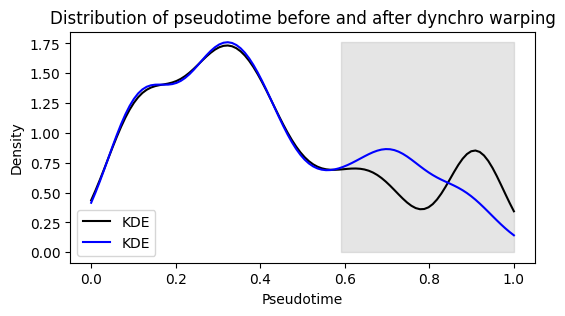

In [17]:
plot_kde_comparison(linC, ["dtw_d1_linC_d2_linC_warped_pseudotime", "orig_pseudotime"], cutoff = endc_start_norm,
                    title = "Distribution of pseudotime before and after dynchro warping")

In [28]:
c_wasserstein = get_wasserstein_distance(linC, pseudotime_keys = ["orig_pseudotime_kde", "dtw_d1_linC_d2_linC_warped_pseudotime_kde"])
print(f"Wasserstein distance before vs after C: {c_wasserstein}")

Wasserstein distance before vs after C: 0.010405988424365731


In [33]:
before, after = get_wasserstein_distance(linC, pseudotime_keys = ["orig_pseudotime_kde", "dtw_d1_linC_d2_linC_warped_pseudotime_kde"], cutoff = endc_start_norm)
print(f"Wasserstein distance before vs after C: {before} vs {after}")

length of distr1: 59, length of distr2: 59
length of distr1 after cutoff: 41, length of distr2 after cutoff: 41
Wasserstein distance before vs after C: 0.0007584526913615102 vs 0.03883455024309617


In [39]:
before_c1 = norm(cells1.obs["pseudotime"])
before_c2 = norm(cells2.obs["pseudotime"])
after_c1 = norm(cells1.obs["warped_pseudotime"])
after_c2 = norm(cells2.obs["warped_pseudotime"])

In [40]:
before_c1_x, before_c1_y, before_c1_kde = get_kde_eval(before_c1, bandwith=0.1)
before_c2_x, before_c2_y, before_c2_kde = get_kde_eval(before_c2, bandwith=0.1)
after_c1_x, after_c1_y, after_c1_kde = get_kde_eval(after_c1, bandwith=0.1)
after_c2_x, after_c2_y, after_c2_kde = get_kde_eval(after_c2, bandwith=0.1)

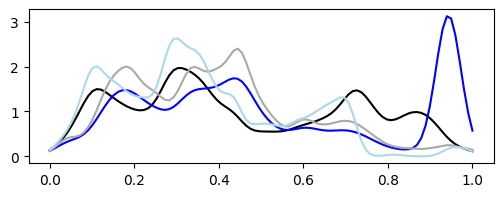

In [41]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(before_c1_x, before_c1_y, label="before c1", color="black")
ax.plot(after_c1_x, after_c1_y, label="after c1", color="blue")
ax.plot(before_c2_x, before_c2_y, label="before c2", color="darkgrey")
ax.plot(after_c2_x, after_c2_y, label="after c2", color="lightblue")

In [42]:
np.save("data/before_c1_x", before_c1_x)
np.save("data/before_c1_y", before_c1_y)
np.save("data/before_c2_x", before_c2_x)
np.save("data/before_c2_y", before_c2_y)
np.save("data/before_pseudotime_x", beforex)
np.save("data/before_pseudotime_y", beforey)
np.save("data/before_pseudotime", before_pseudotime)


In [43]:
# cells 1 is to c
# cells 2 is to d
gt1_simtime = norm(cells1.obs["sim_time"])
gt2_simtime = norm(cells2.obs["sim_time"])
gt1_pseudotime = norm(cells1.obs["pseudotime"])
gt2_pseudotime = norm(cells2.obs["pseudotime"])
gt1_warped_pseudotime = norm(cells1.obs["warped_pseudotime"])
gt2_warped_pseudotime = norm(cells2.obs["warped_pseudotime"])

In [44]:
import scipy.stats

bandwidth = 0.1

# kde from gt1_simtime and gt1_warped_pseudotime
kde_gt1_simtime = scipy.stats.gaussian_kde(gt1_simtime, bw_method=bandwidth)
kde_gt1_pseudotime = scipy.stats.gaussian_kde(gt1_pseudotime, bw_method=bandwidth)

# interpolation points
x_eval = np.linspace(0, 1, 100)
# evaluate kdes
kde_gt1_simtime_eval = kde_gt1_simtime(x_eval)
kde_gt1_pseudotime_eval = kde_gt1_pseudotime(x_eval)

Calculate the differences between the distributions

In [47]:
gt1_simtime

cell952    0.030485
cell530    0.000000
cell600    0.000000
cell79     0.000000
cell685    0.000000
             ...   
cell395    0.576933
cell737    0.592112
cell543    0.850157
cell469    0.941105
cell730    0.576933
Name: sim_time, Length: 668, dtype: float64

In [49]:
# uvalues, vvalues = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
# uweights, vweights are the evaluations of the kde values on the interpolation points

m = scipy.stats.wasserstein_distance(x_eval, x_eval, kde_gt1_simtime_eval, kde_gt1_pseudotime_eval)
print(f"Wasserstein distance between gt1_simtime and gt1_warped_pseudotime: {m}")

Wasserstein distance between gt1_simtime and gt1_warped_pseudotime: 0.12437369573824174


In [45]:
cells2.obs.milestones

cell700          sB
cell989          sB
cell393          sB
cell324          sB
cell847          sB
             ...   
cell952    sC_batch
cell351    sC_batch
cell797    sC_batch
cell603    sC_batch
cell942    sC_batch
Name: milestones, Length: 507, dtype: category
Categories (4, object): ['sB', 'sBmid', 'sC_batch', 'sD']

In [ ]:
def get_milestone_normalised(cells1, cells2, milestone1, milestone2, maxv, time = "pseudotime"):
    milestone_cells = pd.concat([cells1[cells1.obs["milestones"] == milestone1].obs[time], cells2[cells2.obs["milestones"] == milestone2].obs[time]])
    localmax = max(milestone_cells) / maxv
    print(maxv, localmax, max(milestone_cells))
    return pd.concat([norm(milestone_cells, max_value=localmax)])
    

In [55]:
maxall = max(cells1.obs["pseudotime"].max(), cells2.obs["pseudotime"].max())
mbcells = get_milestone_normalised(cells1, cells2, "sB", "sB", maxall)
mccells = get_milestone_normalised(cells1, cells2, "sC", "sC_batch", maxall)
mdcells = get_milestone_normalised(cells1, cells2, "sD", "sD", maxall)
mendccells = get_milestone_normalised(cells1, cells2, "sEndC", "sEndC", maxall)
mbmidcells = get_milestone_normalised(cells1, cells2, "sBmid", "sBmid", maxall)

63.97165927516036 0.3503812447950897 22.414469608438033
63.97165927516036 1.0 63.97165927516036
63.97165927516036 0.5177519451966153 33.12145102716937
63.97165927516036 0.9951497200992941 63.66137882196325
63.97165927516036 0.3929129271236364 25.13529189875918


In [56]:
max_warped = max(cells1.obs["warped_pseudotime"].max(), cells2.obs["warped_pseudotime"].max())
mbcells_warped = get_milestone_normalised(cells1, cells2, "sB", "sB", max_warped, time = "warped_pseudotime")
mccells_warped = get_milestone_normalised(cells1, cells2, "sC", "sC_batch", max_warped, time = "warped_pseudotime")
mdcells_warped = get_milestone_normalised(cells1, cells2, "sD", "sD", max_warped, time = "warped_pseudotime")
mendccells_warped = get_milestone_normalised(cells1, cells2, "sEndC", "sEndC", max_warped, time = "warped_pseudotime")
mbmidcells_warped = get_milestone_normalised(cells1, cells2, "sBmid", "sBmid", max_warped, time = "warped_pseudotime")

63.97165927516036 0.3720879581028783 23.803084076147474
63.97165927516036 0.9949163720064498 63.6464511572753
63.97165927516036 0.4952241574935181 31.680311068003693
63.97165927516036 1.0 63.97165927516036
63.97165927516036 0.41209818080772054 26.36260441054493


In [48]:
# # select cells from milestone sA
# milestone_b_cells = pd.concat([norm(cells1[cells1.obs["milestones"] == "sB"].obs.pseudotime, max_value = max(cells1[cells1.obs["milestones"] == "sB"].obs.pseudotime)), norm(cells2[cells2.obs["milestones"] == "sB"].obs.pseudotime, max_value = max(cells2[cells2.obs["milestones"] == "sB"].obs.pseudotime))])
# # milestone_mid_cells = pd.concat([norm(cells1[cells1.obs["milestones"] == "sBmid"].obs.pseudotime, max_value = max(cells1[cells1.obs["milestones"] == "sBmid"].obs.pseudotime)), norm(cells2[cells2.obs["milestones"] == "sBmid"].obs.pseudotime, max_value = max(cells2[cells2.obs["milestones"] == "sBmid"].obs.pseudotime))])
# milestone_c_cells = pd.concat([norm(cells1[cells1.obs["milestones"] == "sC"].obs.pseudotime, max_value = max(cells1[cells1.obs["milestones"] == "sC"].obs.pseudotime)), norm(cells2[cells2.obs["milestones"] == "sC_batch"].obs.pseudotime, max_value= max(cells2[cells2.obs["milestones"] == "sC_batch"].obs.pseudotime))])
# milestone_d_cells = pd.concat([norm(cells1[cells1.obs["milestones"] == "sD"].obs.pseudotime, max_value = max(cells1[cells1.obs["milestones"] == "sD"].obs.pseudotime)), norm(cells2[cells2.obs["milestones"] == "sD"].obs.pseudotime, max_value= max(cells2[cells2.obs["milestones"] == "sD"].obs.pseudotime))])
# milestone_endc_cells = norm(cells1[cells1.obs["milestones"] == "sEndC"].obs.pseudotime, max_value= max(cells1[cells1.obs["milestones"] == "sEndC"].obs.pseudotime))
# lineagec_cells = pd.concat([milestone_c_cells, milestone_endc_cells])

In [49]:
# max(cells1[cells1.obs["milestones"] == "sB"].obs.pseudotime)

In [50]:
xb, yb, _ = get_kde_eval(mbcells, bandwith=0.1)
xm, ym, _ = get_kde_eval(mbmidcells, bandwith=0.1)
xc, yc, _ = get_kde_eval(mccells, bandwith=0.1)
xd, yd, _ = get_kde_eval(mdcells, bandwith=0.1)
xendc, yendc, _ = get_kde_eval(mendccells, bandwith=0.1)

In [57]:
xbw, ybw, _ = get_kde_eval(mbcells_warped, bandwith=0.1)
xmw, ymw, _ = get_kde_eval(mbmidcells_warped, bandwith=0.1)
xcw, ycw, _ = get_kde_eval(mccells_warped, bandwith=0.1)
xdw, ydw, _ = get_kde_eval(mdcells_warped, bandwith=0.1)
xendcw, yendcw, _ = get_kde_eval(mendccells_warped, bandwith=0.1)

In [51]:
max(mbcells), max(xb)

(0.3503812447950897, np.float64(1.0))

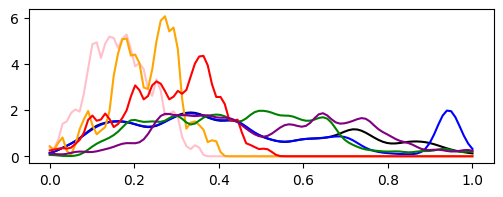

In [52]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(beforex, beforey, label="before", color="black")
ax.plot(afterx, aftery, label="after", color="blue")
ax.plot(xb, yb, label="milestone B", color="pink")
ax.plot(xm, ym, label="milestone Bmid", color="orange")
ax.plot(xc, yc, label="milestone C", color="green")
ax.plot(xd, yd, label="milestone D", color="red")
ax.plot(xendc, yendc, label="milestone EndC", color="purple")

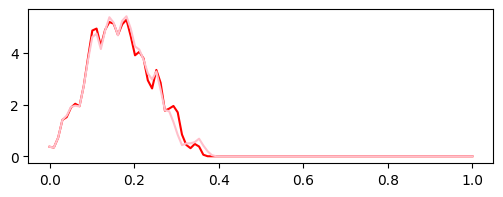

In [58]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(xb, yb, label="milestone B", color="red")
ax.plot(xbw, ybw, label="milestone B warped", color="pink")

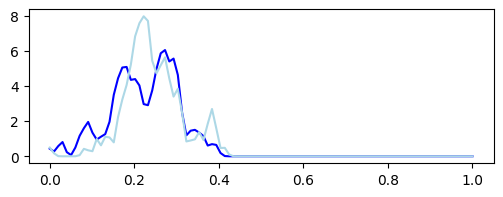

In [60]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(xm, ym, label="milestone Bmid", color="blue")
ax.plot(xmw, ymw, label="milestone Bmid warped", color="lightblue")

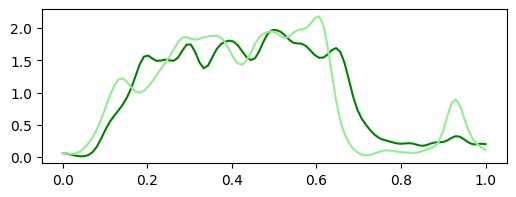

In [59]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(xc, yc, label="milestone C", color="green")
ax.plot(xcw, ycw, label="milestone C warped", color="lightgreen")

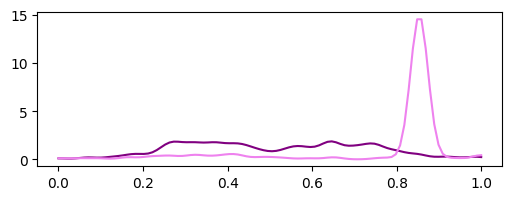

In [61]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(xendc, yendc, label="milestone EndC", color="purple")
ax.plot(xendcw, yendcw, label="milestone EndC warped", color="violet")

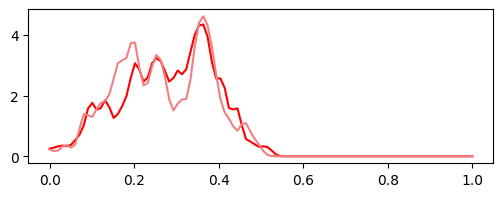

In [62]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(xd, yd, label="milestone D", color="red")
ax.plot(xdw, ydw, label="milestone D warped", color="lightcoral")